## Analyze A/B Test Results

This project will assure you have mastered the subjects covered in the statistics lessons.  The hope is to have this project be as comprehensive of these topics as possible.  Good luck!

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

**As you work through this notebook, follow along in the classroom and answer the corresponding quiz questions associated with each question.** The labels for each classroom concept are provided for each question.  This will assure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the criteria.  As a final check, assure you meet all the criteria on the [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [295]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [296]:
df = pd.read_csv('ab_data.csv')

In [297]:
df.head(4)

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0


b. Use the below cell to find the number of rows in the dataset.

In [298]:
df.shape

(294478, 5)

c. The number of unique users in the dataset.

In [299]:
df['user_id'].nunique()

290584

d. The proportion of users converted.

In [300]:
df['converted'].mean()

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't line up.

In [306]:
df.groupby(['group', 'landing_page']).size()
df[(df['group'] != 'treatment') & (df['landing_page'] == 'new_page')].shape[0] + df[(df['group'] == 'treatment') & (df['landing_page'] != 'new_page')].shape[0]


3893

f. Do any of the rows have missing values?

In [307]:
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to provide how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [308]:
df2 = df[((df['group'] == 'treatment') == (df['landing_page'] == 'new_page')) == True]

In [309]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [310]:
df2['user_id'].nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [311]:
df2[df2['user_id'].duplicated()]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


c. What is the row information for the repeat **user_id**? 

d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [312]:
df2 = df2.drop(index = 2893);

`4.` Use **df2** in the below cells to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [313]:
df2['converted'].mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [328]:
pold = df2[df2['group'] == 'control']['converted'].mean()
pold

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [329]:
pnew = df2[df2['group'] == 'treatment']['converted'].mean()
pnew

0.11880806551510564

d. What is the probability that an individual received the new page?

In [330]:
df2[df2['landing_page'] == 'new_page'].shape[0]/df2.shape[0]

0.5000619442226688

e. Consider your results from a. through d. above, and explain below whether you think there is sufficient evidence to say that the new treatment page leads to more conversions.

There was a 50% chance that either group (treatment or control) landed on the new page so the experiment is balanced. With that being said, because the probability of a user converting given they landed on the treatment page is nearly the same (0.118) as the probability of a user converting given they landed on the control page (0.12) preliminary evidence would suggest that the new treatment page does not lead to more conversions, or that the control page leads to the same amount of conversions (Null Hypothesis).  We can use an A/B test to know for sure. 

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

Null Hypothesis:  Probability of conversion rate for the old page is equal to or more than the new page: **$p_{old}$** >= **$p_{new}$**  
Alternative Hypothesis: Probability of conversion rate for new page is greater than the old page: **$p_{new}$** > **$p_{old}$**

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **convert rate** for $p_{new}$ under the null? 

In [317]:
df2['converted'].mean()


0.11959708724499628

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [318]:
 df2['converted'].mean()


0.11959708724499628

c. What is $n_{new}$?

In [319]:
nnew = df2.groupby('landing_page').size()['new_page']
nnew

145310

d. What is $n_{old}$?

In [320]:
nold=df2.groupby('landing_page').size()['old_page']
nold

145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [321]:
pnew_null = df2['converted']
#pnew = df2[df2['landing_page'] == 'new_page']['converted']
new_page_converted = pnew_null.sample(nnew, replace=True)
new_page_converted.head(10)

156655    0
218703    0
161417    0
167215    1
89431     0
182199    0
56573     0
105120    0
238493    0
199142    1
Name: converted, dtype: int64

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [322]:
pold_null = df2['converted']
old_page_converted = pold_null.sample(nold, replace=True)
old_page_converted.head(10)

54713     0
270329    0
31585     0
235775    0
51784     0
151565    0
268307    0
82757     0
128220    0
44161     0
Name: converted, dtype: int64

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [331]:
diff = new_page_converted.mean() - old_page_converted.mean()
new_page_converted.mean(), old_page_converted.mean(), diff

(0.1190971027458537, 0.11922986907498934, -0.0001327663291356418)

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in a numpy array called **p_diffs**.

In [332]:
#bootstrap the entire dataframe
#then produce a conversion rate of p_old , and a conversion rate of p_new, then take difference
p_diffs = []
samp = df2['converted']
for i in range(10000):
    p_boot_new = samp.sample(nnew,replace=True)
    p_boot_old = samp.sample(nold, replace=True)
    newmean = p_boot_new.mean()
    oldmean = p_boot_old.mean()
    p_diffs.append(newmean - oldmean)

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

(array([  13.,  117.,  737., 2151., 3237., 2509., 1009.,  198.,   25.,
           4.]),
 array([-0.00472379, -0.00370717, -0.00269055, -0.00167394, -0.00065732,
         0.0003593 ,  0.00137591,  0.00239253,  0.00340915,  0.00442577,
         0.00544238]),
 <a list of 10 Patch objects>)

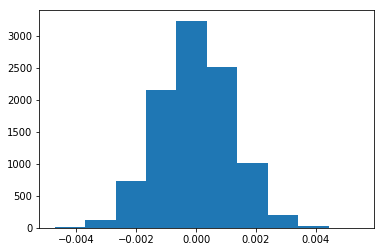

In [333]:
plt.hist(p_diffs)

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [335]:
pnew, pold

(0.11880806551510564, 0.1203863045004612)

In [338]:
obs_diff = pnew - pold
obs_diff

-0.0015782389853555567

In [339]:
p_diffs = np.array(p_diffs)
(p_diffs > obs_diff).mean()

0.9024

k. In words, explain what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

Above we simulated the null distribution that the difference in pold and pnew is 0. The proportion of p_diffs greater than or more extreme than the actual difference observed is the p-value. The p-value is the probability of observing the given statistic (here, observed difference) given that the null is true. In other words, under the condition that the null is true there is a 90% chance that we would have observed the difference in convert rate. Because this p-value is so high (above our Type 1 Error rate) we fail to reject the null hypothesis that the convert rate of the new is the same or less than the convert rate of the old. 

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [340]:
df2.head(5)

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [341]:
import statsmodels.api as sm

convert_old = df2.query('landing_page == "old_page"')['converted'].value_counts()[1]
convert_new = df2.query('landing_page == "new_page"')['converted'].value_counts()[1]
n_old = df2.query('landing_page == "old_page"').shape[0]
n_new = df2.query('landing_page == "new_page"').shape[0]
convert_old, convert_new, n_old, n_new

(17489, 17264, 145274, 145310)

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [342]:
z_score, p_value = sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new])
z_score, p_value

(1.3109241984234394, 0.18988337448195103)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

While the p-value itself is different (a p-value derived from boostrap can be different than traditional hypothesis testing) both the z_score and the p_value here corroborate the above findings that there is no significant difference in convert rates between the old and new page. The Z_score falls below the critical value of 1.96(associated with alpha value of 0.05, 95% confidence). If it were higher than critical value we would have evidence to reject the null. Additionally, the p_value is above our alpha value of 0.05 which means we fail to reject the null. 

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

A logistic regression is most appropriate here. 

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [343]:
df2['intercept'] = 1
df2[['control', 'treatment']] = pd.get_dummies(df['group'])
df2.rename(index=str, columns= {'treatment':'ab_page'}, inplace=True)
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,control,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,1,0


c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [344]:
lm = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
result=lm.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Wed, 13 Feb 2019   Pseudo R-squ.:               8.077e-06
Time:                        15:17:07   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [345]:
1/np.exp(-0.0150)

1.015113064615719

Summary of Results: The coefficient of the ab_page variable indicates that if a user was shown the control page (baseline) the user is 1.015 more likely to convert than if they were shown the treatment page. Additionally, the p_value of 0.19 indicates that there is no significant difference in convert rate between users who were shown the control page and the treatment page. 

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in the **Part II**?

The p_value associated with ab_page is 0.19. This p-value is different from that found via bootstrap methods. The reason why the p-values are different is because in this regression model the null hypothesis is that there is no significant difference in convert_rate between the control and treatment groups holding all other variables constant. This p-value is more consistent with that estimated by the Z-test. 

Additionally, bootstrap method assumes that by resampling multiple times we can approach an estimate of the population parameter. In regression models, that is not the case. 

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

Including other factors into a regression model may result in more accurate predictions because the model can account for more variables that may affect the outcome. Here another variable to consider would be whether the user had already seen the control page before, or how much time each user spent on the page. The disadvantage of doing so is that it makes the results a bit less interpretable because the individual coefficients must be interpreted with respect to all other variables. Additionally, it is possible to over-saturate a model with too many predictors so that only a few are really explaining a large portion of variability in the response data. 

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [346]:
countries_df = pd.read_csv('./countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')
df_new.head(5)

,country,timestamp,group,landing_page,converted,intercept,control,ab_page
user_id,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,0,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,0,1


In [347]:
df_new['country'].value_counts()

US    203619
UK     72466
CA     14499
Name: country, dtype: int64

In [348]:
### Create the necessary dummy variables
df_new[['US', 'UK', 'CA']] = pd.get_dummies(df_new['country'])
df_new.head(5)

,country,timestamp,group,landing_page,converted,intercept,control,ab_page,US,UK,CA
user_id,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,1,0,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,0,1,0,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,0,1,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,1,0,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,0,1,0,1,0


In [349]:
lm= sm.Logit(df_new['converted'], df_new[['intercept', 'ab_page', 'UK', 'CA']])
result = lm.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Wed, 13 Feb 2019   Pseudo R-squ.:               2.323e-05
Time:                        15:17:23   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0300      0.027    -76.249      0.000      -2.082      -1.978
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
UK             0.0506      0.028      1.784      0.074      -0.005       0.106
CA             0.0408      0.027      1.516      0.130      -0.012       0.093
==============================================================================
"""

In [350]:
np.exp(0.05), np.exp(0.04)

(1.0512710963760241, 1.0408107741923882)

The results of this regression indicate that country does not have a significant effect on conversion rate. Compared to the baseline conversion rate in the US, there is no significant difference in the rate in the UK or in CA. If an individual in the US they are only 1.05 times more likely to convert than in the UK and 1.04 times than in CA. 

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [351]:
### Fit Your Linear Model And Obtain the Results
#https://stackoverflow.com/questions/39640672/python-logistic-regression-patsy-design-matrix-and-categorical-data
from patsy import dmatrices

y, X = dmatrices('converted ~ ab_page + ab_page:country', df_new, return_type="dataframe")

X.head(5)



,Intercept,ab_page,ab_page:country[T.UK],ab_page:country[T.US]
user_id,,,,
834778,1.0,0.0,0.0,0.0
928468,1.0,1.0,0.0,1.0
822059,1.0,1.0,1.0,0.0
711597,1.0,0.0,0.0,0.0
710616,1.0,1.0,1.0,0.0


In [352]:
y.head(5)

,converted
user_id,
834778,0.0
928468,0.0
822059,1.0
711597,0.0
710616,0.0


In [353]:
lm = sm.Logit(y, X[['Intercept', 'ab_page','ab_page:country[T.UK]','ab_page:country[T.US]']])
result=lm.fit()
result.summary()



Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Wed, 13 Feb 2019   Pseudo R-squ.:               3.351e-05
Time:                        15:17:38   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                   0.06785
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page                  -0.0827      0.038     -2.176      0.030      -0.157      -0.008
ab_page:country[T.UK]     0.0901      0.040      2.225      0.026       0.011       0.169
ab_page:country[T.US]     0.0644      0.038      1.679      0.093      -0.011       0.140
=========================================================================================
"""

In [354]:
np.exp(0.0901), np.exp(0.064)

(1.0942837066046347, 1.0660923987615052)

The results of this analysis indicate that the way that conversion rate is related to page is dependent on the country. Specifically, it appears that a user in Canada (the baseline) is 1.094 times more likely to convert than counterparts in the UK. Whereas they are only 1.06 times more likely to convert than their counterparts in the United States. In this case now it appears that the treatment page (compared to the baseline of control) significantly influences conversion rate. 

These results are an example of what can happen when new variables are added into regression models. The significance of the variables may change. This may also be an example of Simpsons Paradox where the results can strongly depend on how the data are separated. 

However, it is important to consider practical significance here. Although these results indicate statistical significance it may not be worth it to launch a new page in some countries and keep the control page in others. That seems like a lot of overhead and very pricey. The likelihood of conversion rate increases only slightly when an interaction is added. Considering the results from the above A/B test and this regression analysis, at this point in time I would recommend this company retain the original landing page. 

<a id='conclusions'></a>
## Conclusions

Congratulations on completing the project! 

### Gather Submission Materials

Once you are satisfied with the status of your Notebook, you should save it in a format that will make it easy for others to read. You can use the __File -> Download as -> HTML (.html)__ menu to save your notebook as an .html file. If you are working locally and get an error about "No module name", then open a terminal and try installing the missing module using `pip install <module_name>` (don't include the "<" or ">" or any words following a period in the module name).

You will submit both your original Notebook and an HTML or PDF copy of the Notebook for review. There is no need for you to include any data files with your submission. If you made reference to other websites, books, and other resources to help you in solving tasks in the project, make sure that you document them. It is recommended that you either add a "Resources" section in a Markdown cell at the end of the Notebook report, or you can include a `readme.txt` file documenting your sources.

### Submit the Project

When you're ready, click on the "Submit Project" button to go to the project submission page. You can submit your files as a .zip archive or you can link to a GitHub repository containing your project files. If you go with GitHub, note that your submission will be a snapshot of the linked repository at time of submission. It is recommended that you keep each project in a separate repository to avoid any potential confusion: if a reviewer gets multiple folders representing multiple projects, there might be confusion regarding what project is to be evaluated.

It can take us up to a week to grade the project, but in most cases it is much faster. You will get an email once your submission has been reviewed. If you are having any problems submitting your project or wish to check on the status of your submission, please email us at dataanalyst-project@udacity.com. In the meantime, you should feel free to continue on with your learning journey by beginning the next module in the program.